# Projet 5 : Segmentez des clients d'un site e-commerce

# Partie 3 : Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation

Ce notebook d'analyse de la stabilité des segments au cours du temps est organisé de la manière suivante :

* [**1. Import du jeu de données**](#1.-Import-du-jeu-de-données)
* [**2. Feature engineering**](#2.-Feature-engineering)
* [**3. Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation**](#3.-Simulation-pour-déterminer-la-fréquence-nécessaire-de-mise-à-jour-du-modèle-de-segmentation)
  * [**3.1 Segmentation des clients sur un mois d'une période d'un an**](#3.1-Segmentation-des-clients-sur-un-mois-d'une-période-d'un-an)
  * [**3.2 Analyse de la stabilité des segments par mois sur la période d'un an**](#3.2-Analyse-de-la-stabilité-des-segments-par-mois-sur-la-période-d'un-an)

In [1]:
# Project 5: Segment customers of an e-commerce site
# Part 3: Simulation to determine how often 
# the segmentation model needs to be updated
# Import libraries
import warnings
%pylab inline
import pandas as pd


# Sickit-Learn library
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             adjusted_rand_score)

# Kneed package
from kneed import KneeLocator

# Yellowbrick library
from yellowbrick.cluster import intercluster_distance

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Import du jeu de données

In [2]:
# 1. Loading the segmentation dataset
stability_df = pd.read_csv('stability_df.csv', sep=',')

In [3]:
# Dimensions of the dataset
stability_df.shape

(68423, 11)

In [4]:
# Displaying five first rows of the dataset
stability_df.head()

,customer_unique_id,month,recency,monetary,frequency,review_score,r_score,f_score,m_score,rfm_score,score
0,000d460961d6dbfa3ec6c9f5805769e1,1,283.0,36.68,1,5.0,2,1,1,211,2
1,0014a5a58da615f7b01a4f5e194bf5ea,1,272.0,99.82,1,5.0,2,1,3,213,2
2,0028cfeb9dfcd3628a56d5b6400deef5,1,283.0,118.20,1,5.0,2,1,3,213,2
3,002d3bd901608f67c3fc11eaaa842b13,1,275.0,28.76,1,4.0,2,1,1,211,2
4,002ed12115742033f015cb3c269ccf68,1,260.0,109.79,1,5.0,2,1,3,213,2


## 2. Feature engineering

Nous allons étudier la stabilité du modèle sur les 12 derniers mois des fichiers de données clients : du 18/10/2017 au 17/10/2018.

Nous commençons par la sélection des variables pertinentes.

In [5]:
# 2. Feature engineering
# Selection of relevant features
features = ['recency',
            'frequency',
            'monetary',
            'score',
            'review_score']

## 3. Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation

Nous allons utiliser l'indice de Rand ajusté (ARI, pour Adjusted Rand Index) pour analyser la stabilité de la segmentation. L'indice Rand calcule mesure la similarité entre deux clusterings. La valeur du score ARI des clusters qui sont différents est proche de 0 et proche de 1 pour des clusteurs identiques.

In [6]:
# 3. Simulation to determine how often
# the segmentation model needs to be updated
def find_clusters_number(data):
    """This function finds the optimal cluster number
    by using the KMeans algorithm and elbow method.
    """
    # The optimal number of clusters search
    n_clusters = range(2, 11)
    elbow = {}
    for n_cluster in n_clusters:
        # Instantiate the clustering model
        model = KMeans(
            # The number of clusters and the number 
            # of centroids to generate
            n_clusters=n_cluster,
            # Method for initialization
            init='k-means++',
            # Maximum number of iterations
            max_iter=300,
            # Verbosity mode
            verbose=0,
            # Determines random number generation
            # for centroid initialization
            random_state=0,
            # KMeans algorithm to use
            algorithm='auto')
        model.fit(data)
        elbow[n_cluster] = model.inertia_

    # Using Sum of Squared Errors
    # to find the optimal number of clusters
    kneedle = KneeLocator(
        x=list(elbow.keys()),
        y=list(elbow.values()),
        curve='convex',
        direction='decreasing',
        S=1.0)
    return kneedle.elbow


def displaying_clusters(data, reduced_data, model, x, y, z):
    """This function displays clusters in 2D and 3D projection."""
    # Retrieve the clusters
    clusters = model.labels_

    # 2D plot
    # Setup the figure
    fig = plt.figure(figsize=(8, 8))

    for cluster in np.unique(clusters):
        plt.scatter(
            reduced_data[clusters == cluster, 0],
            reduced_data[clusters == cluster, 1],
            label=cluster,
            alpha=1,
            cmap='viridis')

    # Retrieve the clusters centers
    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        color='black',
        alpha=1)
    plt.legend()
    plt.title("Projection of the {} individuals on "
              "the first factorial plane".format(reduced_data.shape[0]))
    plt.xlabel('F1')
    plt.ylabel('F2')
    plt.show()

    # 3D plot
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(projection='3d')
    df = data.assign(cluster=clusters)
    clusters = list(np.unique(df.cluster))
    for i in clusters:
        ax.scatter(
            df[x][df.cluster == i],
            df[y][df.cluster == i],
            df[z][df.cluster == i],
            s=80,
            label=i)
    ax.view_init(195, 40)
    ax.set_xlabel('{}'.format(x))
    ax.set_ylabel('{}'.format(y))
    ax.set_zlabel('{}'.format(z))
    ax.legend()
    plt.show()


def display_line_plot(x_var, y_var, x_name, y_name, color, int_cord):
    """This function displays a line plot."""
    # Plot
    plt.style.use('seaborn')
    plt.plot(x_var, y_var, 'o-', color=color)

    # Zip joins x and y coordinates in pairs
    for x, y in zip(x_var, y_var):
        if int_cord is True:
            label = "{}".format(int(y))
        else:
            label = "{:.3f}".format(y)
            
        # The text
        plt.annotate(
            label,
            # Coordinates of the label
            (x, y),
            # How to position the text
            textcoords="offset points",
            # Distance between text and points (x, y)
            xytext=(0, 10),
            # Horizontal alignment: left, right or center
            ha='center')
    plt.title('Analysis of {} by {}'.format(y_name, x_name))
    plt.xlabel('{}'.format(x_name))
    plt.ylabel('{}'.format(y_name))
    plt.xticks(rotation=0)
    plt.show()

### 3.1 Segmentation des clients sur un mois d'une période d'un an

Nous allons entrainer un model initial sur le mois de Janvier des 12 derniers mois. Ce modèle va permettre d'effectuer des prédictions pour les autres mois cette période d'un an. Nous allons ensuite entrainer un nouveau modèle chaque mois et comparer les clusters obtenus avec les résultats des prédictions mensuelles.

In [7]:
# 3.1 Customers segmentation over one month of the one-year period
# Creating initial model by using the January datasets
stability_df1 = stability_df[stability_df.month == 1]
month1_df = stability_df1[features]

# Preprocessing
# Normalization
init_transformer = QuantileTransformer(output_distribution='normal',
                                       random_state=0)
norm_df = pd.DataFrame(init_transformer.fit_transform(month1_df),
                       columns=features)

# Standardization
init_scaler = StandardScaler()
norm_df = init_scaler.fit_transform(norm_df)

# Performing PCA
init_pca = decomposition.PCA(n_components=2)
reduced_data = init_pca.fit_transform(norm_df)

# Percentage of variance explained by each component
print("Percentage of variance explained "
      "by each component: ")
print(init_pca.explained_variance_ratio_)
print(init_pca.explained_variance_ratio_.cumsum())

Percentage of variance explained by each component: 
[0.35769932 0.24878521]
[0.35769932 0.60648453]


In [8]:
# Using Elbow method to find the optimal cluster number
N_CLUST = find_clusters_number(reduced_data)

# Instantiate the clustering model
init_model = KMeans(
    # The number of clusters and the number
    # of centroids to generate
    n_clusters=N_CLUST,
    # Method for initialization
    init='k-means++',
    # Maximum number of iterations
    max_iter=300,
    # Verbosity mode
    verbose=0,
    # Determines random number generation
    # for centroid initialization
    random_state=0,
    # KMeans algorithm to use
    algorithm='auto')
init_model.fit(reduced_data)
clusters = init_model.labels_

# Average Silhouette Score
avg_silhouette = silhouette_score(reduced_data, clusters)
print("For n_clust={}, the average".format(N_CLUST),
      "Silhouette Score is: {:.2f}.".format(avg_silhouette))

# Davis-Bouldin Score
db_score = davies_bouldin_score(reduced_data, clusters)
print("The Davis-Bouldin Score "
      "is: {:.2f}.".format(db_score))

For n_clust=5, the average Silhouette Score is: 0.60.
The Davis-Bouldin Score is: 0.52.


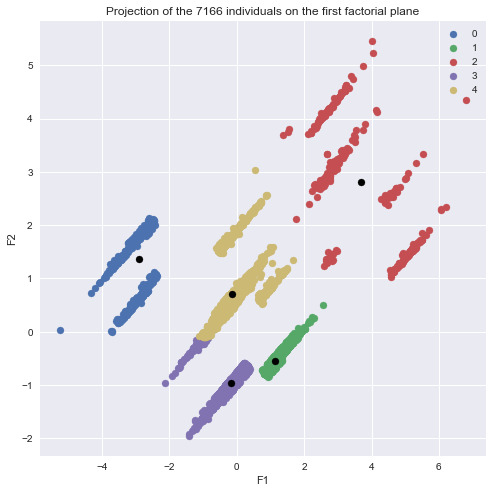

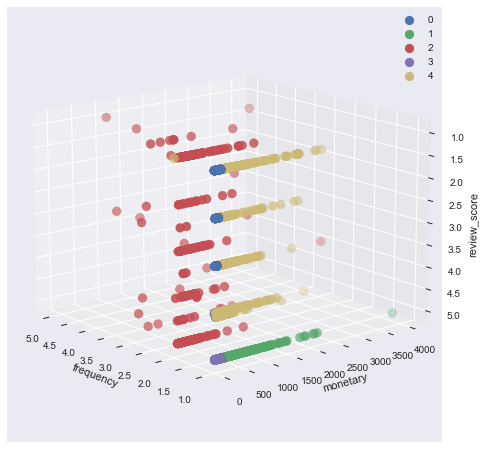

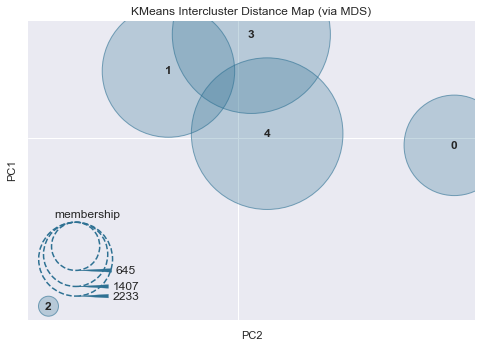

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5, random_state=0),
                     random_state=0)

In [9]:
# Displaying clusters in 2D and 3D projection
displaying_clusters(stability_df1,
                    reduced_data,
                    init_model,
                    'frequency',
                    'monetary',
                    'review_score')

# Displaying Intercluster Distance Maps
intercluster_distance(init_model,
                      reduced_data,
                      random_state=0)

En appliquant le nombre optimale de 5 clusters au modèle du KMeans, on obtient :
- Le coefficient de Silhouette moyen de 0,6 ;
- L’index de Davis-Bouldin de 0,52.

### 3.2 Analyse de la stabilité des segments par mois sur la période d'un an

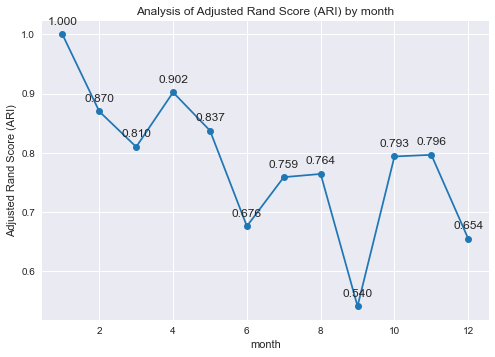

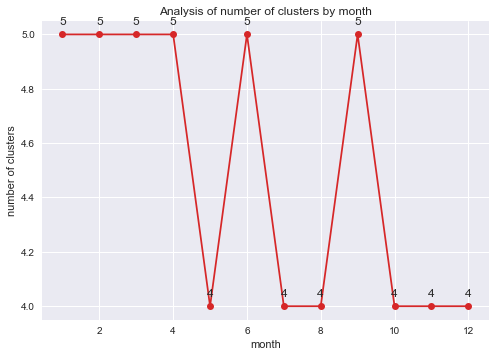

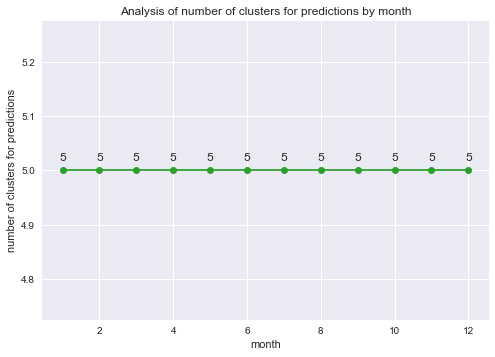

In [10]:
# 3.2 Segments stability analysis by month over the one-year period
months = np.unique(list(stability_df.month))
ari = []
clusters_number = []
pred_clusters_number = []
for month in months:
    # Month selection
    month_df = stability_df[stability_df.month == month]
    month_df = month_df[features]
    
    # Preprocessing
    # Normalization
    norm_df = init_transformer.transform(month_df)
    
    # Standardization
    norm_df = init_scaler.transform(norm_df)
    
    # Performing PCA
    data_reduced = init_pca.transform(norm_df)
    
    # Prediction
    # Using initial model of the first month for prediction
    labels = init_model.fit_predict(data_reduced)
    pred_clusters_number.append(len(np.unique(labels)))
    
    # Preprocessing
    # Normalization
    transformer = QuantileTransformer(output_distribution='normal',
                                      random_state=0)
    norm_df = pd.DataFrame(transformer.fit_transform(month_df),
                           columns=features)
    # Standardization
    scaler = StandardScaler()
    norm_df = scaler.fit_transform(norm_df)

    # Performing PCA
    pca = decomposition.PCA(n_components=2)
    reduced_data = pca.fit_transform(norm_df)
    
    # Using Elbow method to find the optimal cluster number
    N_CLUST = find_clusters_number(reduced_data)
    clusters_number.append(N_CLUST)
    
    # Instantiate the clustering model
    model = KMeans(
        n_clusters=N_CLUST,
        init='k-means++',
        max_iter=300,
        random_state=0,
        algorithm='auto')
    
    # Training the model
    model.fit(reduced_data)
    clusters = model.labels_
    ari.append(adjusted_rand_score(clusters, labels))

# Displaying Adjusted Rand Score
display_line_plot(months,
                  ari,
                  'month',
                  'Adjusted Rand Score (ARI)',
                  'tab:blue',
                  False)

# Displaying Number of clusters
display_line_plot(months,
                  clusters_number,
                  'month',
                  'number of clusters',
                  'tab:red',
                  True)

# Displaying Number of clusters for predictions
display_line_plot(months,
                  pred_clusters_number,
                  'month',
                  'number of clusters for predictions',
                  'tab:green',
                  True)

L'analyse de la courbe de l’indice de Rand ajusté permet d'observer :
- Une forte inflexion à partir du mois d'Avril ;
- Des inflexions plus ou moins importantes tous les 1 à 2 mois.


L'analyse du nombre de clusters obtenus pour chaque entrainement mensuel permet d'observer :
- Un changement du nombre de clusters à partir du mois d'Avril ;
- Des changements du nombre de clusters tous les 1 à 2 mois.

Il faut donc effectuer la mise à jour du modèle tous les mois à partir du mois d'Avril.